In [1]:
%matplotlib inline


500 hPa Geopotential Heights and Winds
======================================

Classic 500-hPa plot using NAM analysis file.

This example uses example data from the NAM anlysis for 12 UTC 31
October 2016 and uses xarray as the main read source with using Cartopy
for plotting a CONUS view of the 500-hPa geopotential heights, wind
speed, and wind barbs.


Import the needed modules.




In [36]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np
from scipy.ndimage import gaussian_filter
import xarray as xr
from cartopy.io.shapereader import Reader

The following code reads the example data using the xarray open_dataset
function and prints the coordinate values that are associated with the
various variables contained within the file.




In [3]:
ds = xr.open_dataset('/public/home/hysplit/data/ERA/ERA-500hpa_2018-01-17_20.nc')
ds.coords

Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2018-01-17 ... 2018-01-20T23:00:00

In [5]:
hght = ds['z']

In [6]:
hght.shape

(96, 721, 1440)

In [21]:
hght2018=hght.mean(dim=["time"])

In [13]:
dsuv = xr.open_dataset('/public/home/hysplit/data/ERA/ERA-500hpa_uv-2018-01-17_20.nc')
dsuv.coords

Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2018-01-17 ... 2018-01-20T23:00:00

In [14]:
u=dsuv["u"]

In [16]:
u2018=u.mean(dim=["time"])

In [18]:
v=dsuv["v"]

In [20]:
v2018=v.mean(dim=["time"])

In [26]:
ds1 = xr.open_dataset('/public/home/hysplit/data/ERA/ERA5-1979-2019-month-500hpa.nc')
ds1.coords

Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1979-01-01 1980-01-01 ... 2019-01-01

In [27]:
hght_avg = ds1['z']

In [28]:
hght_avg.shape

(41, 721, 1440)

In [41]:
hght_avg500=hght_avg.mean(dim=["time"])

In [42]:
hght_diff500 =hght2018-hght_avg500

In [43]:
hght_diff500.min()

<xarray.DataArray 'z' ()>
array(-2903.753906)

In [47]:
hght_diff500.max()

<xarray.DataArray 'z' ()>
array(2809.164062)

Data Retrieval
--------------

This code retrieves the necessary data from the file and completes some
smoothing of the geopotential height and wind fields using the SciPy
function gaussian_filter. A nicely formated valid time (vtime) variable
is also created.




In [25]:
# Grab lat/lon values (NAM will be 2D)
lats = ds.latitude.data
lons = ds.longitude.data

# Select and grab data

# Select and grab 500-hPa geopotential heights and wind components, smooth with gaussian_filter
hght_500 = gaussian_filter(hght2018, sigma=3.0)
uwnd_500 = gaussian_filter(u2018, sigma=3.0) * units('m/s')
vwnd_500 = gaussian_filter(v2018, sigma=3.0) * units('m/s')

# Use MetPy to calculate the wind speed for colorfill plot, change units to knots from m/s
#sped_500 = mpcalc.wind_speed(uwnd_500, vwnd_500).to('kt')

# Create a clean datetime object for plotting based on time of Geopotential heights
vtime = datetime.strptime(str(ds.time.data[0].astype('datetime64[ms]')),
                          '%Y-%m-%dT%H:%M:%S.%f')

Map Creation
------------

This next set of code creates the plot and draws contours on a Lambert
Conformal map centered on -100 E longitude. The main view is over the
CONUS with geopotential heights contoured every 60 m and wind speed in
knots every 20 knots starting at 30 kt.




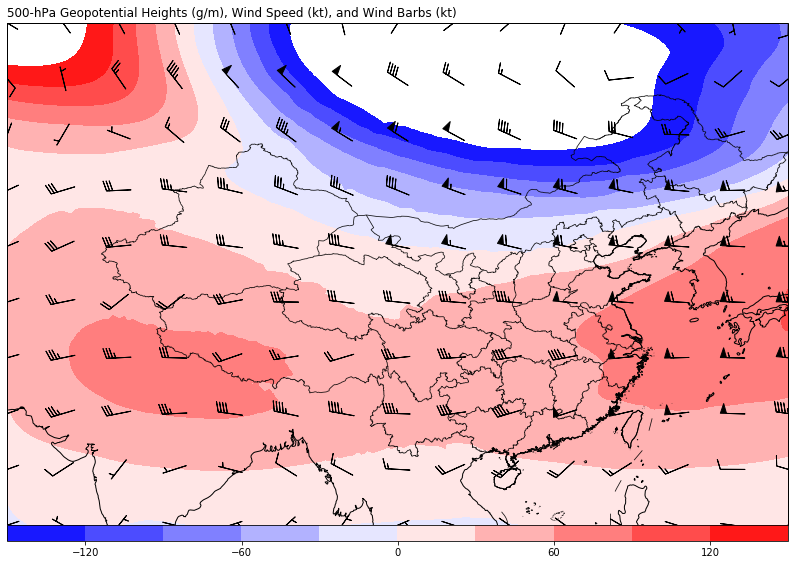

In [49]:
# Set up the projection that will be used for plotting
mapcrs = ccrs.PlateCarree(central_longitude=110)

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)
ax.set_extent([65, 135, 15, 60], ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

states_provinces = cfeature.NaturalEarthFeature(
            category='cultural',  name='admin_1_states_provinces_lines',
            scale='50m',facecolor='none')
ax.add_feature(states_provinces, edgecolor='gray', zorder=10)
fname = '/public/home/hysplit/data/map/cnhimap.shp'
#fname = 'D:\data\map\prd_9city.shp'
adm1_shapes = list(Reader(fname).geometries())
ax.add_geometries(adm1_shapes, crs=ccrs.PlateCarree(),edgecolor='black', facecolor='none', alpha=0.9,linewidths=0.8)
    
# Plot 500-hPa Colorfill Wind Speeds in knots
clevs_500_sped = np.arange(-150, 180, 30)
cf = ax.contourf(lons, lats, hght_diff500/9.8, clevs_500_sped, cmap=plt.cm.bwr,
                 transform=datacrs)
plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50)

# Plot 500-hPa Geopotential Heights in meters
clevs_500_hght = np.arange(0, 8000, 60)
cs = ax.contour(lons, lats, hght_500, clevs_500_hght, colors='black',
                transform=datacrs)
plt.clabel(cs, fmt='%d')

# Plot 500-hPa wind barbs in knots, regrid to reduce number of barbs
ax.barbs(lons, lats, uwnd_500.to('kt').m, vwnd_500.to('kt').m, pivot='middle',
         color='black', regrid_shape=10, transform=datacrs)

# Make some nice titles for the plot (one right, one left)
plt.title('500-hPa Geopotential Heights (g/m), Wind Speed (kt),'
          ' and Wind Barbs (kt)', loc='left')
#plt.title('Valid Time: {}'.format(vtime), loc='right')

# Adjust image and show
plt.subplots_adjust(bottom=0, top=1)
plt.savefig("500hpa-nanjing.png",dpi=600)